<a href="https://colab.research.google.com/github/AnnaPikuleva/DataScince_task/blob/main/catch_me_if_you_can.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
 !gdown --id 1aAVxXvmrX63bQebhCRhS7RJO9x7wtW_g
 !gdown --id 1YWUzIPyt25t0Ixqp972G2eu-pJaUhLtE
 !gdown --id 1JGGpmTbhFYL1Oz6x3OtRfCrlzBEJ_9O2

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aAVxXvmrX63bQebhCRhS7RJO9x7wtW_g
To: /content/test_sessions.csv
100% 19.5M/19.5M [00:00<00:00, 130MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YWUzIPyt25t0Ixqp972G2eu-pJaUhLtE
To: /content/train_sessions.csv
100% 60.5M/60.5M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.googl

https://newtechaudit.ru/gruzi-daty-krasivo/ - как прочитать правильно колонку с датами 

In [ ]:
train_df = pd.read_csv('/content/train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('/content/test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])

In [ ]:
#смотрим на форму датафрэйма
print(f"train_df shape: {train_df.shape}, test_df shape: {test_df.shape}")

train_df shape: (253561, 21), test_df shape: (82797, 20)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  object        
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  object        
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  object        
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  object        
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  object        
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  object        
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  object        
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  obje

In [ ]:
#все колонки где есть слова time пеобразуем в формат datetime
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортиурем по времени 
train_df = train_df.sort_values(by='time1')

#все колонки где есть слова site пеобразуем в формат int
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [ ]:
# выделяем целевую переменную 
y_train = train_df['target']
# объединяем два датафрэйма (переде этим удаляем из тренировочных данных целевую переменную )
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

In [ ]:
#количество записей в тренировочном датасэте
idx_split = train_df.shape[0]
idx_split

253561

In [ ]:
full_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [ ]:
 #выбираем только колонки с сайтами 
full_sites = full_df[sites]
full_sites.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


##Countvectorizer — это метод преобразования текста в числовые данные

https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

Проанализируем количество повторений каждого сайта 

In [ ]:
#преобразуем все сайты к строковому типу и сделаем из них список 
full_sites = full_sites.astype('str')
lst = full_sites[sites].to_numpy().tolist()
#все номера сайтов в одну строку списком 
flat_list = [' '.join(sublist) for sublist in lst]

In [ ]:
#  max_features=50000 - количество самых рапространенных слов, которые выберет алгоритм 
# ngram_range=(1, 3) - 1 это минимальный размер текстовой ячейки, 3 - максимальный размер 
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
sites_matrix = cv.fit_transform(flat_list)

In [ ]:
# Разделяем обратно на трэйн и тест
train_sites_matrix = sites_matrix[:idx_split]
test_sites_matrix  = sites_matrix[idx_split:]

print(f"train_sites_matrix shape: {train_sites_matrix.shape}, test_sites_matrix shape: {test_sites_matrix.shape}")

# cv.get_feature_names()[:10]

train_sites_matrix shape: (253561, 50000), test_sites_matrix shape: (82797, 50000)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '10 1086',
 '10 11',
 '10 11 12',
 '10 11 14',
 '10 11 15',
 '10 11241',
 '10 1199',
 '10 12',
 '10 1200']

In [ ]:
#выбираем все колонки со временем
full_time = full_df[times] 
full_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


In [ ]:
# функция для делелния на периоды по времени 
def add_features(time_df):
    start_hour = time_df['time1'].apply(lambda ts: ts.hour)
    # содали новый датафрэйм где индексы id пользователей, значениям - начало сессии
    additional_data_df = pd.DataFrame(data=start_hour.values, columns=['start_hour'], index=start_hour.index)
    additional_data_df['morning'] = ((start_hour >= 7) & (start_hour <= 11)).astype('int').values.reshape(-1, 1)
    additional_data_df['midday'] = ((start_hour >= 12) & (start_hour <= 18)).astype('int').values.reshape(-1, 1)
    additional_data_df['evening'] = ((start_hour >= 19) & (start_hour <= 23)).astype('int').values.reshape(-1, 1)
    additional_data_df['night'] = ((start_hour >= 0) & (start_hour <= 6)).astype('int').values.reshape(-1, 1)
    additional_data_df['sess_duration'] = (time_df.max(axis=1) - time_df.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int').values.reshape(-1, 1)
    additional_data_df['day_of_week'] = time_df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    additional_data_df['month'] = time_df['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    return additional_data_df

## **Categorical quantitative features**

* **Categorical variables** take category or label values and place an individual into one of several groups   
  Each observation can be placed in only one category, and the categories are mutually exclusive. 
* **Quantitative variables** take numerical values and represent some kind of measurement. 

In [ ]:
additional_data_df = add_features(full_time)
print(additional_data_df.shape)
additional_data_df.head(5)

(336358, 8)


,start_hour,morning,midday,evening,night,sess_duration,day_of_week,month
session_id,,,,,,,,
21669,8,1,0,0,0,0,5,1
54843,8,1,0,0,0,1786,5,1
77292,8,1,0,0,0,4,5,1
114021,8,1,0,0,0,3,5,1
146670,8,1,0,0,0,2,5,1


In [ ]:
# возьеме логарифм от колонки с длительностью, чтобы она не выделялась из всего списка
additional_data_df['sess_duration'] =  np.log1p(additional_data_df['sess_duration'].values)
additional_data_df.head(5)

,start_hour,morning,midday,evening,night,sess_duration,day_of_week,month
session_id,,,,,,,,
21669,8,1,0,0,0,0.000000,5,1
54843,8,1,0,0,0,7.488294,5,1
77292,8,1,0,0,0,1.609438,5,1
114021,8,1,0,0,0,1.386294,5,1
146670,8,1,0,0,0,1.098612,5,1


In [ ]:
# снова разобьем на тестовые и тренировочны данные
add_data_train = additional_data_df[: idx_split].copy() 
add_data_test = additional_data_df[idx_split :]


add_data_train.loc[:, 'target' ] = y_train

In [ ]:
# посмотрим на вид данных 
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

,Column_name,Column_type
0,start_hour,int64
1,morning,int64
2,midday,int64
3,evening,int64
4,night,int64
5,sess_duration,float64
6,day_of_week,int64
7,month,int64
8,target,float64


##Матрица корреляции

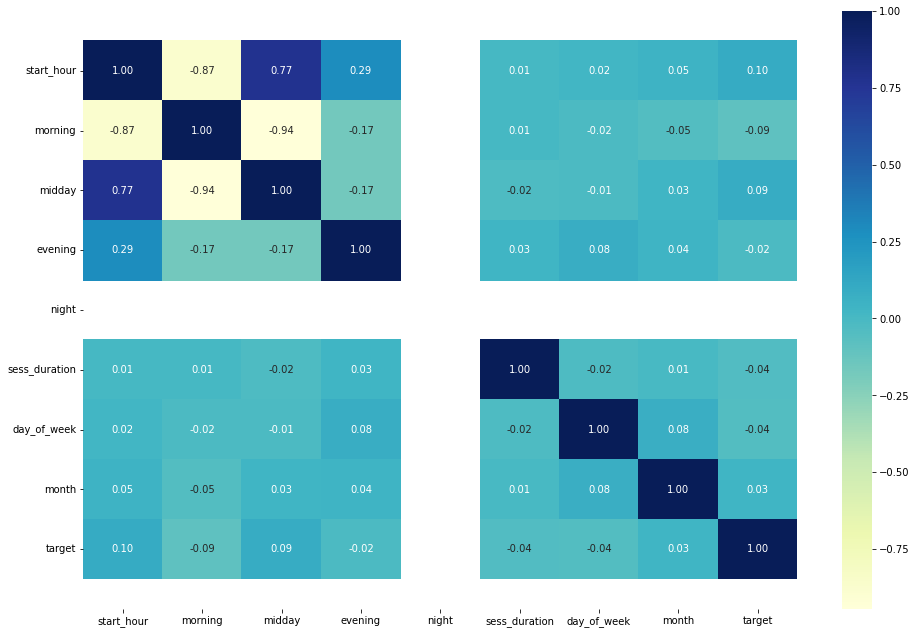

In [ ]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize=(16, 11)) 
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f');
i, k = ax.get_ylim()
ax.set_ylim(i + 0.5, k - 0.5);

In [ ]:
# удалим колонку ночь, так как она почти ни с чем не коррлирует 
add_data_train = add_data_train.drop('night', 1)
add_data_test = add_data_test.drop('night', 1)

<ipython-input-82-69e385928166>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  add_data_train = add_data_train.drop('night', 1)
<ipython-input-82-69e385928166>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  add_data_test = add_data_test.drop('night', 1)


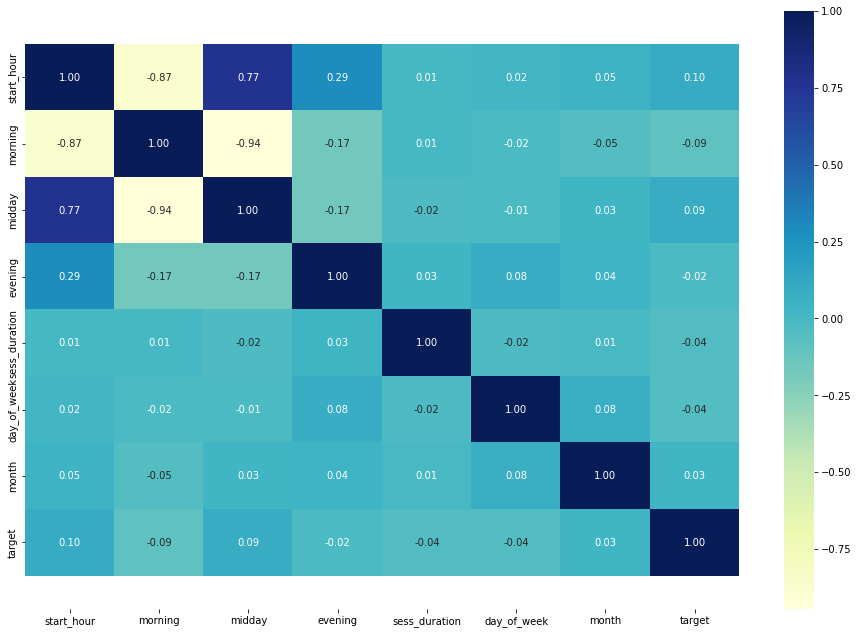

In [ ]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize=(16, 11)) 
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f');
i, k = ax.get_ylim()
ax.set_ylim(i + 0.5, k - 0.5);

In [ ]:
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

,Column_name,Column_type
0,start_hour,int64
1,morning,int64
2,midday,int64
3,evening,int64
4,sess_duration,float64
5,day_of_week,int64
6,month,int64
7,target,int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

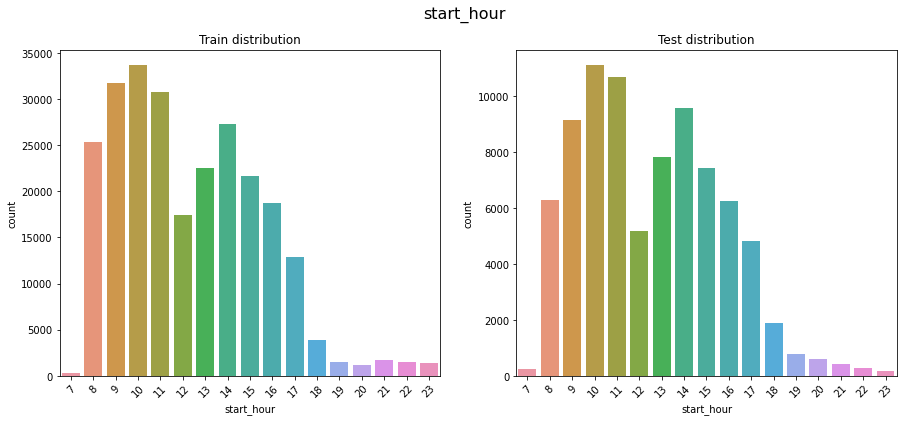

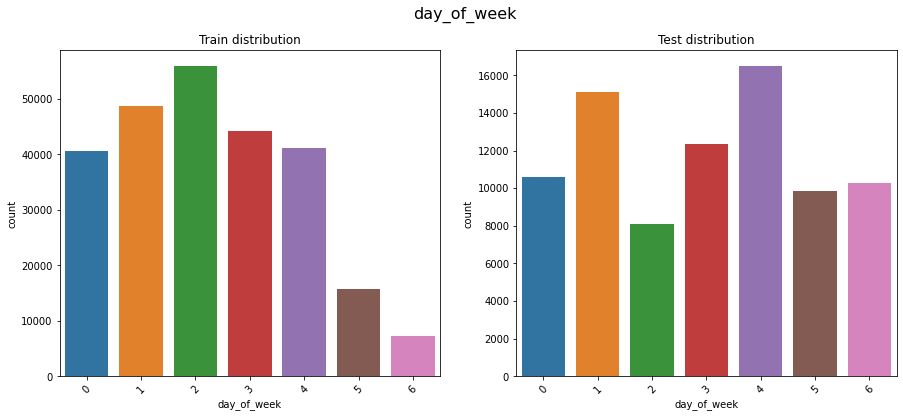

In [ ]:
# Посмотрим как распредяликось количество пользователей по дням недели и началу работы в тренировочных и тестовых данных 
feature_list = ['start_hour', 'day_of_week'] 
for column_name in feature_list: 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
    fig.suptitle(column_name, fontsize=16) 
    sns.countplot(add_data_train[column_name], ax=ax1) 
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(add_data_test[column_name], ax=ax2) 
    ax2.set_title("Test distribution") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

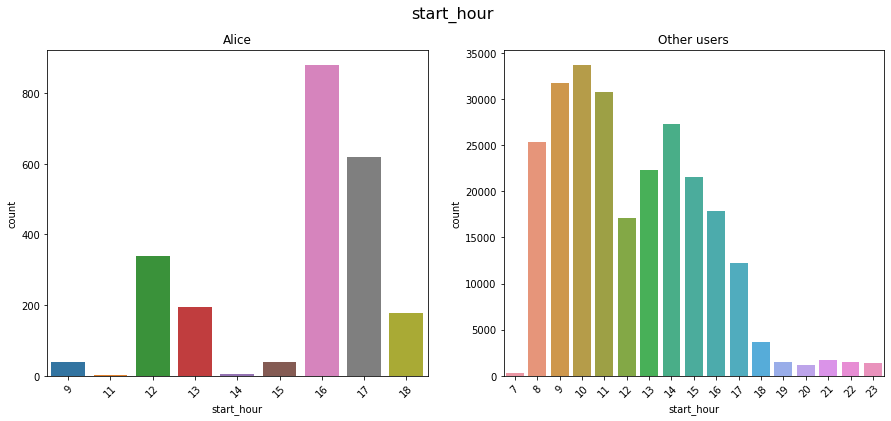

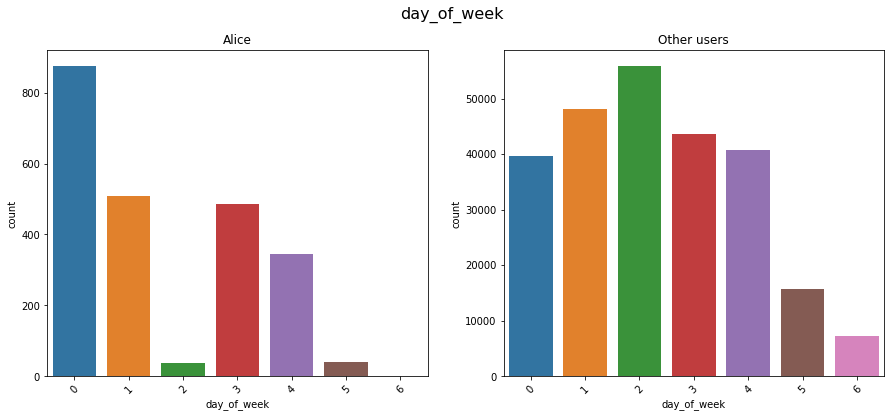

In [ ]:
# посмотрим как распределсиь целевые функции
for column_name in feature_list:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
    fig.suptitle(column_name, fontsize=16) 
    sns.countplot(add_data_train[add_data_train['target'] == 1][column_name], ax=ax1) 
    ax1.set_title("Alice") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(add_data_train[add_data_train['target'] == 0][column_name], ax=ax2) 
    ax2.set_title("Other users") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

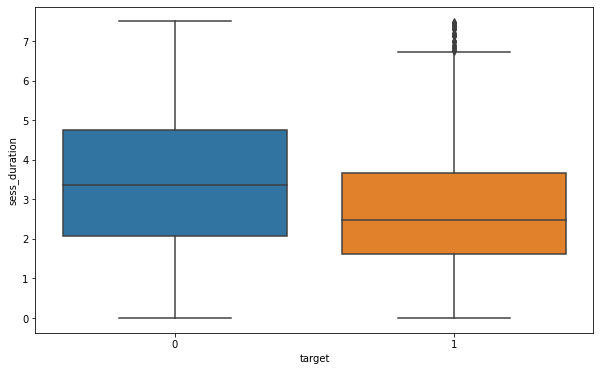

In [ ]:
# посмотрим на длительность сессии
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x = 'target', y = 'sess_duration', data = add_data_train)

In [ ]:
add_data_train.head(5)

,start_hour,morning,midday,evening,sess_duration,day_of_week,month,target
session_id,,,,,,,,
21669,8,1,0,0,0.000000,5,1,0.0
54843,8,1,0,0,7.488294,5,1,NaN
77292,8,1,0,0,1.609438,5,1,0.0
114021,8,1,0,0,1.386294,5,1,0.0
146670,8,1,0,0,1.098612,5,1,0.0


## One hot encoding

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

In [ ]:
# ковертируем день недели методом One hot encoding
add_train_dummies  = pd.get_dummies(add_data_train , columns=['day_of_week']) 
add_train_dummies.drop(['target'],axis = 1,inplace=True) 
add_test_dummies  = pd.get_dummies(add_data_test,columns=['day_of_week'])

In [ ]:
add_train_dummies.head()

,start_hour,morning,midday,evening,sess_duration,month,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
session_id,,,,,,,,,,,,,
21669,8,1,0,0,0.000000,1,0,0,0,0,0,1,0
54843,8,1,0,0,7.488294,1,0,0,0,0,0,1,0
77292,8,1,0,0,1.609438,1,0,0,0,0,0,1,0
114021,8,1,0,0,1.386294,1,0,0,0,0,0,1,0
146670,8,1,0,0,1.098612,1,0,0,0,0,0,1,0


## Стандартизируем переменные

Стандартизация данных — это процесс масштабирования атрибутов таким образом, чтобы их среднее значение равнялось 0, а дисперсия — 1.


Конечная цель выполнения стандартизации состоит в том, чтобы привести все признаки к общей шкале, не искажая различий в диапазоне значений.


В sklearn.preprocessing.StandardScaler() центрирование и масштабирование происходит независимо для каждой функции.

используем fit_transform() для обучающих данных, а transform() для тестовых данных

In [ ]:
names_for_scale = list(add_train_dummies.columns)
scaler = StandardScaler() 
for column_name in names_for_scale : 
    # values - Возвращает Numpy-представление DataFrame.
    # reshape(-1, 1) - приводит к одномерному массиву
    add_train_dummies[column_name] = scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1, 1)) 
    add_test_dummies[column_name] = scaler.transform(add_test_dummies[column_name].values.reshape(-1, 1))

In [ ]:
add_test_dummies.head()

,start_hour,morning,midday,evening,sess_duration,month,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
session_id,,,,,,,,,,,,,
1,-0.407823,1.039061,-0.981280,-0.171577,-0.750303,1.474950,-0.436072,-0.487314,-0.53223,-0.459143,-0.440082,3.879327,-0.172561
2,-0.407823,1.039061,-0.981280,-0.171577,0.571882,0.668778,-0.436072,-0.487314,-0.53223,2.177972,-0.440082,-0.257777,-0.172561
3,0.858234,-0.962408,1.019077,-0.171577,0.565370,2.012399,-0.436072,-0.487314,-0.53223,-0.459143,2.272305,-0.257777,-0.172561
4,-0.724338,1.039061,-0.981280,-0.171577,-1.011969,1.743675,-0.436072,2.052067,-0.53223,-0.459143,-0.440082,-0.257777,-0.172561
5,0.858234,-0.962408,1.019077,-0.171577,-0.438748,0.131329,-0.436072,-0.487314,-0.53223,-0.459143,2.272305,-0.257777,-0.172561


In [ ]:
# объединим данные о сайтах и временные переменные
x_train_full = csr_matrix(hstack([train_sites_matrix, add_train_dummies.values])) 
x_test_full = csr_matrix(hstack([test_sites_matrix, add_test_dummies.values])) 
x_train_full.shape, x_test_full.shape

((253561, 50013), (82797, 50013))

In [ ]:
target = train_df['target']
X_train , X_valid , y_train , y_valid = train_test_split(x_train_full,target ,test_size=0.2) 
tscv = TimeSeriesSplit(n_splits=5);

LogisticRegression

In [ ]:
%%time
# clf_lr = LogisticRegression(random_state=42, n_jobs=-1)
clf_lr = LogisticRegression(random_state=42, n_jobs=-1, max_iter=500)
clf_lr.fit(X_train, y_train)

preds_lr = clf_lr.predict_proba(X_valid)[:, 1]
print('Train test split LogisticRegression score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_lr), 4))

cross_score_lr = np.mean(cross_val_score(clf_lr, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print('Cross validation LogisticRegression score:% s ROC AUC'% round (cross_score_lr, 4))

Train test split LogisticRegression score:0.9809 ROC AUC
Cross validation LogisticRegression score:0.9115 ROC AUC
CPU times: user 376 ms, sys: 108 ms, total: 483 ms
Wall time: 48.2 s


RandomForestClassifier

In [ ]:
%%time
# clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict_proba(X_valid)[:, 1]
print ('Train test split RandomForestClassifier score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_rf), 4))
cross_score_rf = np.mean (cross_val_score (clf_rf, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

Train test split RandomForestClassifier score:0.9791 ROC AUC
Cross validation RandomForestClassifier score:0.8249 ROC AUC
CPU times: user 6min 53s, sys: 1.5 s, total: 6min 54s
Wall time: 14min 20s


XGBClassifier

In [ ]:
%%time
# clf_xgb = xgb.XGBClassifier(random_state = 42, n_jobs=-1)
clf_xgb = xgb.XGBClassifier(random_state = 42, booster = 'gblinear', n_jobs=-1)
clf_xgb.fit(X_train, y_train)
preds_xgb = clf_xgb.predict_proba(X_valid)[:, 1]
print ('Train test split XGBClassifier score:% s ROC AUC'% round(roc_auc_score(y_valid, preds_xgb), 4))
cross_score_xgb = np.mean (cross_val_score (clf_xgb, x_train_full, target, scoring = 'roc_auc', n_jobs=-1, cv=tscv))
print ('Cross validation XGBClassifier score:% s ROC AUC'% round (cross_score_xgb, 4))

Train test split XGBClassifier score:0.9142 ROC AUC


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross validation XGBClassifier score:0.8666 ROC AUC
CPU times: user 14.8 s, sys: 979 ms, total: 15.8 s
Wall time: 35 s


<ipython-input-33-023dc37a950b>:15: MatplotlibDeprecationWarning: Unrecognized location 'lowerright'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='lowerright')


Text(0.5, 0, 'False Positive Rate')

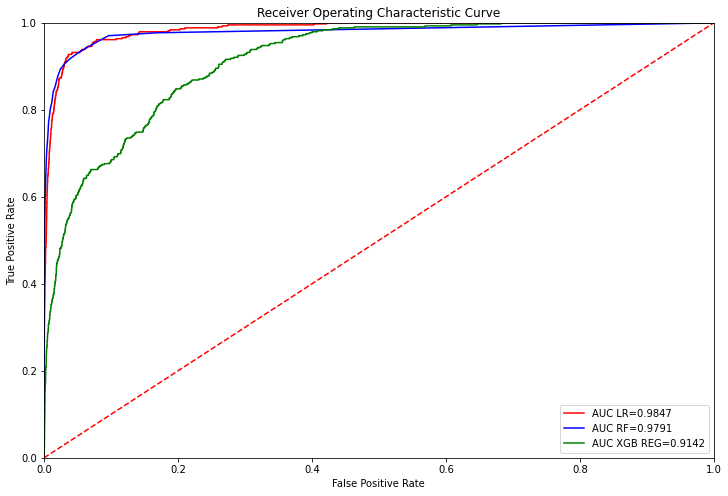

In [ ]:
fpr_lr, tpr_lr, threshold = roc_curve(y_valid, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, threshold = roc_curve(y_valid, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, threshold = roc_curve(y_valid, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_lr, tpr_lr, 'r', label='AUC LR=%0.4f'%roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'b', label='AUC RF=%0.4f'%roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, 'g', label='AUC XGB REG=%0.4f'%roc_auc_xgb)
plt.legend(loc='lowerright')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
def show_confusion_matrix(y_true, y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true.values, y_pred)
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(4, 3)
    fig.suptitle(title, fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5] * len([0, 1]),
                        rowLabels=['True 0','True 1'], colLabels=['Predicted 0', 'Predicted 1'],
                        cellLoc='center', rowLoc='center', loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1, 4)
    plt.show()

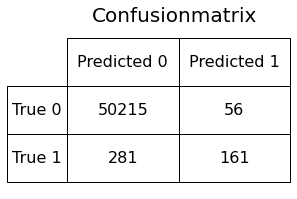

In [ ]:
# матрица по логистической регрессии
show_confusion_matrix(y_valid, clf_lr.predict(X_valid))

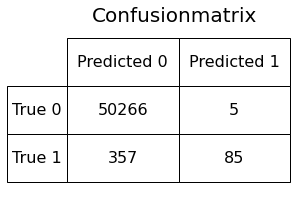

In [ ]:
# матрица по деревьям решений
show_confusion_matrix(y_valid, clf_rf.predict(X_valid))

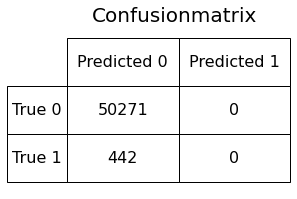

In [ ]:
# XGBClassifier
show_confusion_matrix(y_valid, clf_xgb.predict(X_valid))

In [ ]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,max_iter=8000,n_jobs=-1,solver='lbfgs').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    return score

In [ ]:
from tqdm import tqdm
# List of possible C-values
Cs = np.logspace(-1, 1, 20)

scores = []

for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 20/20 [03:57<00:00, 11.89s/it]


In [ ]:
Cs

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

In [ ]:
max(scores)

0.9856027850468005

In [ ]:
final_model = LogisticRegression(random_state = 17, C = Cs[np.argmax(scores)],n_jobs=1) 
final_model.fit(X_train,y_train) 
print('ROC_AUC on the test sample: {} '.format(round(roc_auc_score(y_valid,final_model.predict_proba(X_valid)[:,1]),4)))

ROC_AUC on the test sample: 0.9804 


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
